## 1. Identifición del problema 
- Predecir el tiempo de entrega para un envio
- Predicción del costo 
- Probabilidad de cumplimiento (habrá demora o no)

## 2. Adquisión de datos

In [432]:
import pandas as pd
import numpy as np

# --- Cargar datos ---
df = pd.read_csv("smart_logistics_dataset.csv")

# --- 1) Renombrar columnas a español (idempotente) ---
mapa = {
    "Timestamp": "marca_tiempo",
    "Asset_ID": "id_activo",
    "Latitude": "latitud",
    "Longitude": "longitud",
    "Inventory_Level": "nivel_inventario",
    "Shipment_Status": "estado_envio",
    "Temperature": "temperatura",
    "Humidity": "humedad",
    "Traffic_Status": "estado_trafico",
    "Waiting_Time": "tiempo_espera",
    "User_Transaction_Amount": "monto_transaccion_usuario",
    "User_Purchase_Frequency": "frecuencia_compra_usuario",
    "Logistics_Delay_Reason": "motivo_retraso_logistico",
    "Asset_Utilization": "utilizacion_activo",
    "Demand_Forecast": "pronostico_demanda",
    "Logistics_Delay": "retraso_logistico",
}
df.rename(columns=mapa, inplace=True)


In [433]:
# --- 2) Exploración y limpieza de los datos ---
# Ver las primeras filas del DataFrame
df.head()

,marca_tiempo,id_activo,latitud,longitud,nivel_inventario,estado_envio,temperatura,humedad,estado_trafico,tiempo_espera,monto_transaccion_usuario,frecuencia_compra_usuario,motivo_retraso_logistico,utilizacion_activo,pronostico_demanda,retraso_logistico
0,2024-03-20 00:11:14,Truck_7,-65.7383,11.2497,390,Delayed,27.0,67.8,Detour,38,320,4,NaN,60.1,285,1
1,2024-10-30 07:53:51,Truck_6,22.2748,-131.7086,491,In Transit,22.5,54.3,Heavy,16,439,7,Weather,80.9,174,1
2,2024-07-29 18:42:48,Truck_10,54.9232,79.5455,190,In Transit,25.2,62.2,Detour,34,355,3,NaN,99.2,260,0
3,2024-10-28 00:50:54,Truck_9,42.3900,-1.4788,330,Delivered,25.4,52.3,Heavy,37,227,5,Traffic,97.4,160,1
4,2024-09-27 15:52:58,Truck_7,-65.8477,47.9468,480,Delayed,20.5,57.2,Clear,56,197,6,NaN,71.6,270,1


In [434]:
# Ver información general del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   marca_tiempo               1000 non-null   object 
 1   id_activo                  1000 non-null   object 
 2   latitud                    1000 non-null   float64
 3   longitud                   1000 non-null   float64
 4   nivel_inventario           1000 non-null   int64  
 5   estado_envio               1000 non-null   object 
 6   temperatura                1000 non-null   float64
 7   humedad                    1000 non-null   float64
 8   estado_trafico             1000 non-null   object 
 9   tiempo_espera              1000 non-null   int64  
 10  monto_transaccion_usuario  1000 non-null   int64  
 11  frecuencia_compra_usuario  1000 non-null   int64  
 12  motivo_retraso_logistico   737 non-null    object 
 13  utilizacion_activo         1000 non-null   float6

In [435]:
#  Ver los valores que puede tomar una columna categórica
print(df["estado_envio"].value_counts())
print(" ")
print(df["estado_trafico"].value_counts())
print(" ")
print(df["motivo_retraso_logistico"].value_counts())

estado_envio
Delayed       350
Delivered     338
In Transit    312
Name: count, dtype: int64
 
estado_trafico
Detour    345
Clear     328
Heavy     327
Name: count, dtype: int64
 
motivo_retraso_logistico
Weather               267
Traffic               236
Mechanical Failure    234
Name: count, dtype: int64


**Observaciones:**
- Solamente la columnas de motivo_retraso_logistico posee valores nulos. Pero no se van a eliminar, ya que estos **son los casos sin retraso**.
- La marca de tiempo es un objecto, podríamos arreglar la clolumna al separar la fecha en otras columnas.

## 3. Preparación de los datos
Vamos a modificar las columnas para poder tener los datos en un estado optimo:
- Vamos a cambiar los nulos de motivo_retraso_logistico por un valor categoríco **"No reportado"**.
- Vamos a modificar la columna de de fecha para que sea un DateTime.

In [436]:
# Reemplazar NaN por 0
df["motivo_retraso_logistico"] = df["motivo_retraso_logistico"].fillna("No reportado")
print(df["motivo_retraso_logistico"].value_counts())

motivo_retraso_logistico
Weather               267
No reportado          263
Traffic               236
Mechanical Failure    234
Name: count, dtype: int64


In [437]:
# Convertir a datetime
df["marca_tiempo"] = pd.to_datetime(df["marca_tiempo"])

# Crear nuevas columnas
df["mes"] = df["marca_tiempo"].dt.month        # mes (1-12)
df["dia"] = df["marca_tiempo"].dt.day          # día (1-31)
df["hora"] = df["marca_tiempo"].dt.hour        # hora (0-23)



## 4. EDA
- Tabla de correlaciones

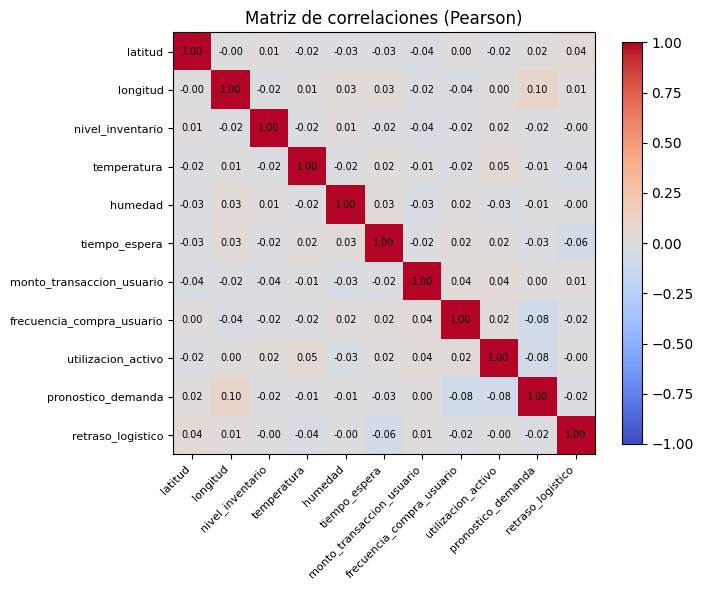

In [438]:
import matplotlib.pyplot as plt
# Seleccionar numéricas
num_df = df.select_dtypes(include=["float64", "int64"])

# Correlación
corr = num_df.corr()

# Heatmap
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)

# Labels
ax.set_xticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right", fontsize=8)
ax.set_yticks(range(len(corr.index)))
ax.set_yticklabels(corr.index, fontsize=8)

# Valores en celdas
for i in range(len(corr.index)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", color="black", fontsize=7)

plt.title("Matriz de correlaciones (Pearson)")
plt.colorbar(im, fraction=0.03, pad=0.04)
plt.tight_layout()
plt.show()


**Obeservaciones:**
* No hay correlaciones claras o fuertes entre las variables númericas.
* Podrían combinarse variables para conseguir mayor correlaciones.

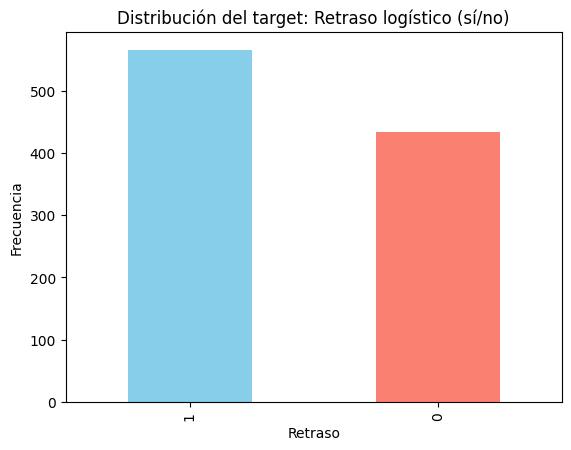

In [439]:
# Distribución del target
df["retraso_logistico"].value_counts().plot(kind="bar", color=["skyblue", "salmon"])
plt.title("Distribución del target: Retraso logístico (sí/no)")
plt.xlabel("Retraso")
plt.ylabel("Frecuencia")
plt.show()


**Observaciones:**
* Más de la mitad de los pedidos tiene un estado de Retraso
* Ver en que casos los pedidos no tienen retrasos

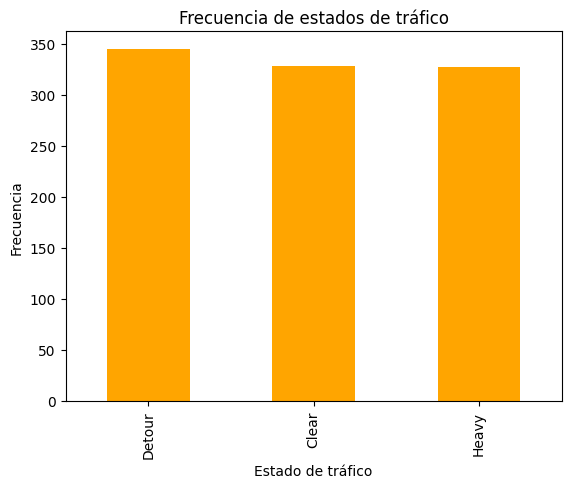

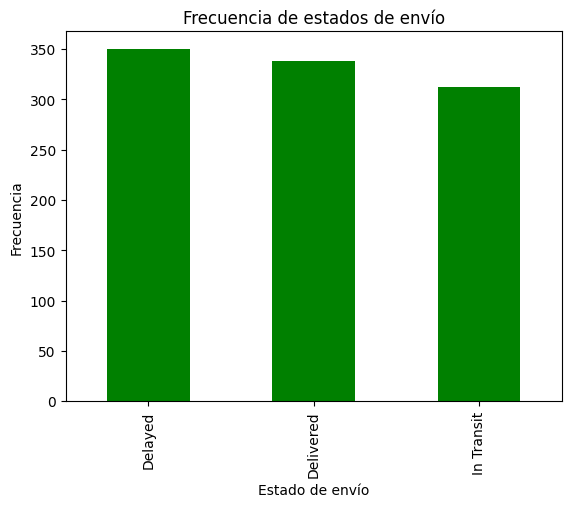

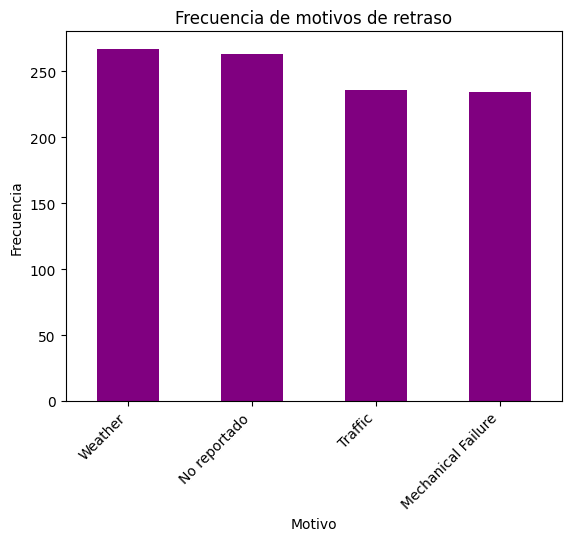

In [440]:
# Estado de tráfico
df["estado_trafico"].value_counts().plot(kind="bar", color="orange")
plt.title("Frecuencia de estados de tráfico")
plt.xlabel("Estado de tráfico")
plt.ylabel("Frecuencia")
plt.show()

# Estado de envío
df["estado_envio"].value_counts().plot(kind="bar", color="green")
plt.title("Frecuencia de estados de envío")
plt.xlabel("Estado de envío")
plt.ylabel("Frecuencia")
plt.show()

# Motivos de retraso
df["motivo_retraso_logistico"].fillna("No reportado").value_counts().plot(kind="bar", color="purple")
plt.title("Frecuencia de motivos de retraso")
plt.xlabel("Motivo")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45, ha="right")
plt.show()


**Observaciones:**
* Hay una buena cantidad de pedidos sin retrasos
* No hay mucha variación en las ditribuciones en las 3 variables categoricas
* Podríamos observar la distribución del estado de retraso del pedido en las 3 variables categoricas

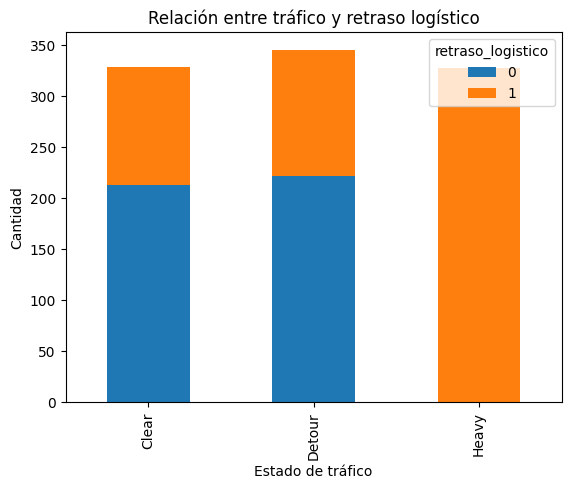

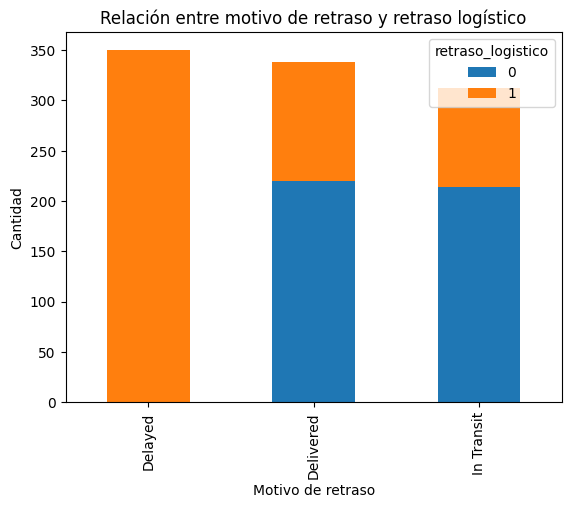

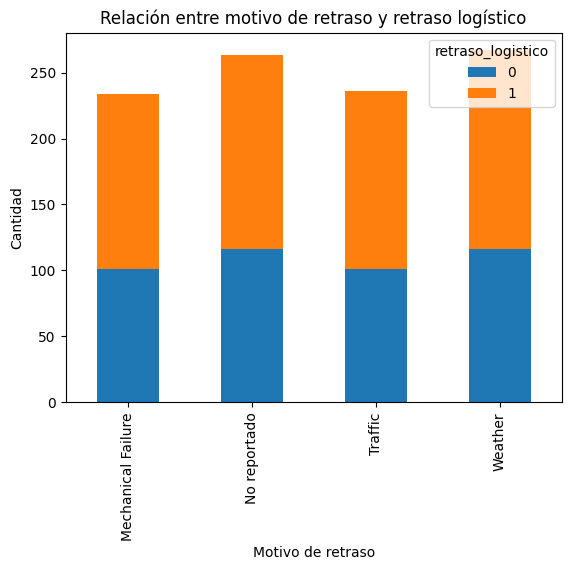

In [441]:
# Tráfico vs Retraso
pd.crosstab(df["estado_trafico"], df["retraso_logistico"]).plot(kind="bar", stacked=True)
plt.title("Relación entre tráfico y retraso logístico")
plt.xlabel("Estado de tráfico")
plt.ylabel("Cantidad")
plt.show()

# Estado de envío VS Retraso
pd.crosstab(df["estado_envio"], df["retraso_logistico"]).plot(kind="bar", stacked=True)
plt.title("Relación entre motivo de retraso y retraso logístico")
plt.xlabel("Motivo de retraso")
plt.ylabel("Cantidad")
plt.show()

# Motivo de retraso VS Retraso
pd.crosstab(df["motivo_retraso_logistico"], df["retraso_logistico"]).plot(kind="bar", stacked=True)
plt.title("Relación entre motivo de retraso y retraso logístico")
plt.xlabel("Motivo de retraso")
plt.ylabel("Cantidad")
plt.show()


**Observación:** 
* Vemos que cuando el trafico esta **Pesado** todos los pedidos tienen un estado de **Retraso**.
* Vemos que todos los pedidos entregados con retraso, presentaron un tipo de retraso. Sin embargo, los pedidos entregados en el tiempo, tambien los presentaron.

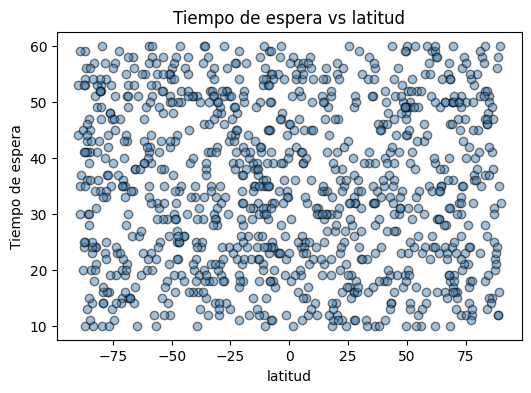

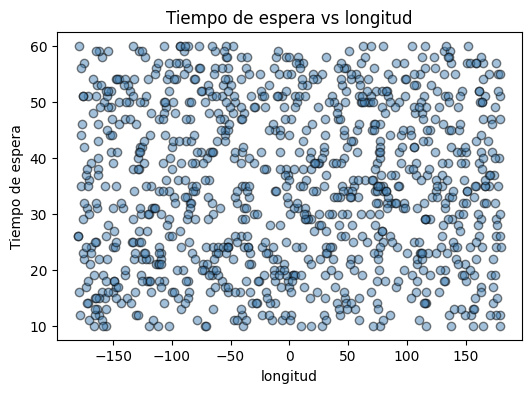

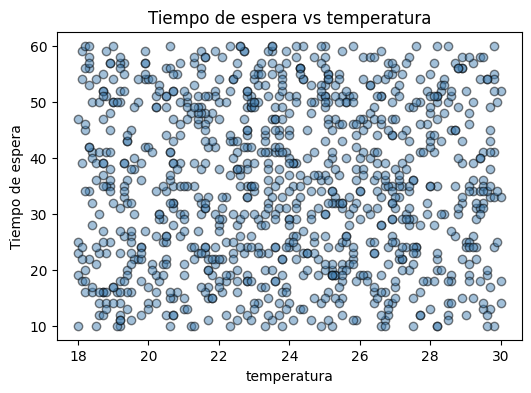

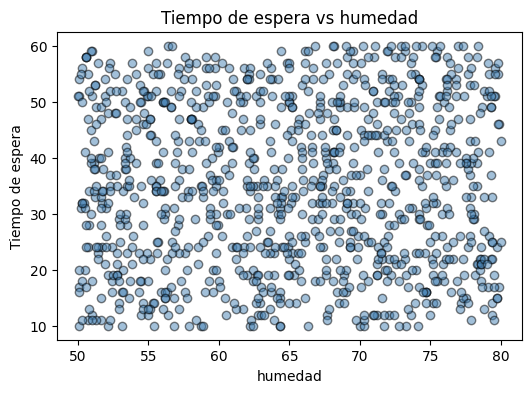

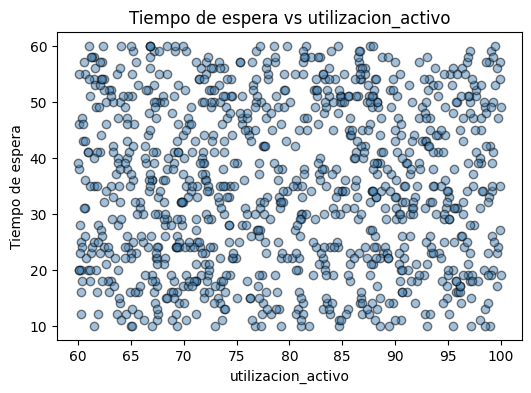

In [442]:
# Seleccionamos las variables numéricas
num_cols = df.select_dtypes(include=["float64"]).columns

# Quitamos la propia variable objetivo
num_cols = [col for col in num_cols if col != "tiempo_espera"]

# Hacemos scatterplots
for col in num_cols:
    plt.figure(figsize=(6,4))
    plt.scatter(df[col], df["tiempo_espera"], alpha=0.5, color="steelblue", edgecolors="k")
    plt.title(f"Tiempo de espera vs {col}")
    plt.xlabel(col)
    plt.ylabel("Tiempo de espera")
    plt.show()

**Observación:**
* No se observa una relación clara entre las variables númericas
* Los datos estan muy dispersos

## 5. Modelamiento de datos

### Predicción del tiempo 
* Vamos a utlizar como grountruth el **tiempode espera**.

Intentamos investigar o inferir alguna manera de poder determiar el tiempo por pedido en ser entregado, pero no había una forma clara y sin incoherencias de hacerlo.

Una opción era tracker el mismo camión (ejem. truck_8), para que cuando el estaus del pedido cambie a **entregado** se calcule el tiempo desde los registros anteriores. Pero luego enonctramos 2 tuplas seguidas con (los días consecutivos) que tenian el estado de **entregado** y ahí encontramos una ambiguedad que no supimos como abordar.

### Predicción del costo
* Para la predicción de costo usaremos las variable de **monto de transacción de usuario** como groundtruth.

### Probabilidad de cumplimiento
* Ya tenemos un groundtruth explicito

Observamos un posible problema, cuando se entrena un modelo de clasificación es fundamental evitar el data leakage, es decir, el uso de variables que contienen información que no estaría disponible en el momento de la predicción o que son consecuencias directas del target.

## Modelos
1. Predicción de Tiempo : Regresión
2. Predicción de Costo : Regresión 
3. Clasificación de probabilidad de cumplimiento: Logistico (0 o 1)

**1. Predicción para el tiempo**

In [443]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from joblib import dump

# Config
target_time = "tiempo_espera"
categorical_features = ["estado_envio", "estado_trafico", "motivo_retraso_logistico"]
numeric_features = ["nivel_inventario", "temperatura", "humedad", 
                    "utilizacion_activo", "pronostico_demanda", "frecuencia_compra_usuario"]

# Preprocesamiento
X = df[numeric_features + categorical_features]
y = df[target_time].values.reshape(-1, 1)

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = encoder.fit_transform(X[categorical_features])
scaler = StandardScaler()
X_num = scaler.fit_transform(X[numeric_features])

# Guardar preprocesadores
dump(encoder, "encoder_eta.joblib")
dump(scaler, "scaler_eta.joblib")

# Combinar numéricas y categóricas + bias
X_all = np.hstack([X_num, X_cat])
X_all = np.c_[np.ones((X_all.shape[0], 1)), X_all]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)

# Modelo desde cero
def linear_regression_gd(X, y, lr=0.01, epochs=2000):
    m, n = X.shape
    theta = np.zeros((n, 1))
    for epoch in range(epochs):
        y_pred = X.dot(theta)
        error = y_pred - y
        gradients = (2/m) * X.T.dot(error)
        theta -= lr * gradients
        if epoch % 500 == 0:
            mse = np.mean(error**2)
            print(f"Epoch {epoch}, MSE: {mse:.4f}")
    return theta

theta = linear_regression_gd(X_train, y_train, lr=0.01, epochs=2000)
y_pred_test = X_test.dot(theta)
print("\n📊 ETA - Tiempo de espera")
print("MAE:", mean_absolute_error(y_test, y_pred_test))
print("R2:", r2_score(y_test, y_pred_test))

# Wrapper y guardado
class LinearRegressionFromScratch:
    def __init__(self, theta):
        self.theta = theta
    def predict(self, X):
        if X.shape[1] + 1 == len(self.theta):
            X = np.c_[np.ones((X.shape[0], 1)), X]
        return X.dot(self.theta)

dump(LinearRegressionFromScratch(theta), "reg.joblib")

Epoch 0, MSE: 1433.0463
Epoch 500, MSE: 205.1220
Epoch 1000, MSE: 205.0980
Epoch 1500, MSE: 205.0978

📊 ETA - Tiempo de espera
MAE: 12.84274545229241
R2: -0.025287444190089436


['reg.joblib']

**2. Predicción para el costo**

In [444]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

target_cost = "monto_transaccion_usuario"

X_num = df[numeric_features].values
y = df[target_cost].values.reshape(-1, 1)

encoder_cost = OneHotEncoder(handle_unknown="ignore")
X_cat = encoder_cost.fit_transform(df[categorical_features]).toarray()
scaler_cost = StandardScaler()
X_num_scaled = scaler_cost.fit_transform(X_num)

# Guardar preprocesadores
dump(encoder_cost, "encoder_cost.joblib")
dump(scaler_cost, "scaler_cost.joblib")

X_all_cost = np.hstack([X_num_scaled, X_cat])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_all_cost, y, test_size=0.2, random_state=42)

# Gradiente descendente desde cero
def gradient_descent(X, y, lr=0.01, epochs=1000):
    n_samples, n_features = X.shape
    W = np.zeros((n_features, 1))
    b = 0
    for epoch in range(epochs):
        y_pred = X @ W + b
        error = y_pred - y
        dW = (2/n_samples) * X.T @ error
        db = (2/n_samples) * np.sum(error)
        W -= lr * dW
        b -= db
        if epoch % 200 == 0:
            loss = np.mean(error**2)
            print(f"Epoch {epoch}, Loss: {loss:.4f}")
    return W, b

W, b = gradient_descent(X_train, y_train, lr=0.01, epochs=1000)
y_pred_test = X_test @ W + b
print("\n📊 Monto transacción")
print("MAE:", mean_absolute_error(y_test, y_pred_test))
print("R2:", r2_score(y_test, y_pred_test))

# Wrapper y guardado
class LinearRegressionCostFromScratch:
    def __init__(self, W, b):
        self.W = W
        self.b = b
    def predict(self, X):
        return X @ self.W + self.b

dump(LinearRegressionCostFromScratch(W, b), "reg_cost.joblib")

Epoch 0, Loss: 102960.5587
Epoch 200, Loss: 131595633.8071
Epoch 400, Loss: 194062538951.5765
Epoch 600, Loss: 286211200418390.5000
Epoch 800, Loss: 422115764327275968.0000

📊 Monto transacción
MAE: 24949432233.381943
R2: -4.344633034361272e+16


['reg_cost.joblib']

**Observación de ambas predicciones:**
- Al no encontrar correlaciones claras e importantes, decidimos en ambos casos utilizar una regresión lineal al aser algo sencillo de implementar.
- Previamente habiamos probado con diversos tipos de modelos, pero los resultados eran peores. Al final nos decidimos por el caso lineal.
- En ambos casos las métricas son **pesimas**, ya que son negativas, esto quiere decir que al predecir ni se acercan al promedio.

**3. Clasificación para la probabilidad de demora**

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

target_delay = "retraso_logistico"
categorical_features_delay = ["estado_trafico"]  # variables conocidas antes del retraso

X = df[numeric_features + categorical_features_delay]
y = df[target_delay].values.reshape(-1, 1)

preprocessor_delay = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features_delay)
    ]
)
X_proc = preprocessor_delay.fit_transform(X)
if hasattr(X_proc, "toarray"):
    X_proc = X_proc.toarray()

X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic regression desde cero
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(y, y_hat):
    m = len(y)
    eps = 1e-15
    return -(1/m) * np.sum(y * np.log(y_hat + eps) + (1 - y) * np.log(1 - y_hat + eps))

def logistic_regression_train(X, y, lr=0.01, epochs=1000):
    m, n = X.shape
    W = np.zeros((n, 1))
    b = 0
    for i in range(epochs):
        z = X @ W + b
        y_hat = sigmoid(z)
        dz = y_hat - y
        W -= lr * (X.T @ dz)/m
        b -= lr * np.sum(dz)/m
        if i % 200 == 0:
            loss = compute_loss(y, y_hat)
            print(f"Epoch {i}, Loss: {loss:.4f}")
    return W, b

W_delay, b_delay = logistic_regression_train(X_train, y_train, lr=0.1, epochs=1000)

# Evaluación
y_pred = (sigmoid(X_test @ W_delay + b_delay) >= 0.5).astype(int)
from sklearn.metrics import accuracy_score, classification_report
print("\n📊 Retraso logístico")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Reporte:\n", classification_report(y_test, y_pred))

# Wrapper y guardado
class LogisticRegressionFromScratch:
    def __init__(self, W, b):
        self.W = W
        self.b = b
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    def predict_proba(self, X):
        z = X @ self.W + self.b
        return np.hstack([1 - self.sigmoid(z), self.sigmoid(z)])
    def predict(self, X):
        return (self.sigmoid(X @ self.W + self.b) >= 0.5).astype(int)

dump(LogisticRegressionFromScratch(W_delay, b_delay), "logreg.joblib")
dump(preprocessor_delay, "preprocessor_delay.joblib")

Epoch 0, Loss: 0.6931
Epoch 200, Loss: 0.4873
Epoch 400, Loss: 0.4612
Epoch 600, Loss: 0.4525
Epoch 800, Loss: 0.4483

📊 Retraso logístico
Accuracy: 0.775
Reporte:
               precision    recall  f1-score   support

           0       0.66      1.00      0.79        87
           1       1.00      0.60      0.75       113

    accuracy                           0.78       200
   macro avg       0.83      0.80      0.77       200
weighted avg       0.85      0.78      0.77       200



['preprocessor_delay.joblib']

**Observamos:**

* Exactitud total = 77.5% 
Es bastante aceptable considerando que quitamos variables que daban trampa (leakage).

* Esto indica que, en promedio, acierta en 3 de cada 4 predicciones.

* **Metricas por clase**
    - Clase 0 (no hay retraso)

        * Precision = 0.66: cuando predice “no hay retraso”, acierta un 66%.

        * Recall = 1.00: detectó todos los casos reales sin retraso, no se le escapó ninguno.

        * F1 = 0.79: balance intermedio.

    - Clase 1 (sí hay retraso)

        * Precision = 1.00: cuando dice “sí hay retraso”, nunca se equivoca.

        * Recall = 0.60: pero solo logra encontrar el 60% de los retrasos reales → se le escapan 4 de cada 10 casos de retraso.

        * F1 = 0.75: aceptable pero limitado por el recall.